In [1]:
import numpy as np
import pandas as pd
import string
import tensorflow as tf
from tensorflow import keras

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Load Data
dataset = pd.read_csv('../Lyric-Generation-Project/lyric_corpus.csv', dtype=str)[:-1]

In [3]:
def create_lyrics_corpus(dataset, field):
    # Remove all other punctuation
    dataset[field] = dataset[field].str.replace('[{}]'.format(string.punctuation), '')
    # Make it lowercase
    dataset[field] = dataset[field].str.lower()
    # Make it one long string to split by line
    lyrics = dataset[field].str.cat()
    corpus = lyrics.split('\n')
    # Remove any trailing whitespace
    for l in range(len(corpus)):
        corpus[l] = corpus[l].rstrip()
    # Remove any empty lines
    corpus = [l for l in corpus if l != '']
    return corpus

In [4]:
#Create Corpus
corpus = create_lyrics_corpus(dataset, 'Lyrics')
corpus[0:6]

['turnpike gates lyricsspoken',
 'in order for you to play with this record we must tune your guitar to ours we will start with the first string',
 'chorus',
 'we would drag ourselves to bed',
 'and sleep took everything i had',
 'i kept it up till he would call']

# Tokenizer

In [45]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [48]:
tokenizer = Tokenizer()

def get_sequence_of_tokens(corpus):
    ## tokenization
    tokenizer.fit_on_texts(corpus)
    total_words = len(tokenizer.word_index) + 1
    
    ## convert data to sequence of tokens 
    input_sequences = []
    for line in corpus:
        token_list = tokenizer.texts_to_sequences([line])[0]
        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i+1]
            input_sequences.append(n_gram_sequence)
    return input_sequences, total_words

inp_sequences, total_words = get_sequence_of_tokens(corpus)
inp_sequences[:10]

# One-hot encode the labels
one_hot_labels = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

model = Sequential()
model.add(Embedding(total_words, 64, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(20)))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(input_sequences, one_hot_labels, epochs=5, verbose=1)

# Text Vectorization

In [5]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [6]:
vectorizer = TextVectorization(max_tokens=10600, output_sequence_length=200)
#text_ds = tf.data.Dataset.from_tensor_slices(train_samples).batch(128)
vectorizer.adapt(corpus)

In [7]:
vectorizer.get_vocabulary()[50:65]

['one',
 'can',
 'now',
 'want',
 'mark',
 'are',
 'no',
 'again',
 'get',
 'what',
 'see',
 'youre',
 'way',
 'na',
 'away']

In [8]:
# Test the vectorizer
output = vectorizer([["What a great day in New York"]])
output.numpy()[0, :7]

array([  59,    7,  817,  114,    9,  286, 2037])

In [9]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))
len(word_index)

10568

In [10]:
#Test is again now that it is in a dictionary
test = ["what", "a", "great", "day", "in", "new", "york"] # has to be in lowercase
[word_index[w] for w in test]

[59, 7, 817, 114, 9, 286, 2037]

# Download Glove embeddings

In [11]:
!brew install wget

Running `brew update --auto-update`...
==> Auto-updated Homebrew!
Updated 1 tap (homebrew/core).

You have 2 outdated formulae installed.
You can upgrade them with brew upgrade
or list them with brew outdated.

==> Downloading https://ghcr.io/v2/homebrew/core/gettext/manifests/0.21.1
######################################################################## 100.0%
==> Downloading https://ghcr.io/v2/homebrew/core/gettext/blobs/sha256:9318777367
==> Downloading from https://pkg-containers.githubusercontent.com/ghcr1/blobs/sh
######################################################################## 100.0%
==> Downloading https://ghcr.io/v2/homebrew/core/libunistring/manifests/1.0
######################################################################## 100.0%
==> Downloading https://ghcr.io/v2/homebrew/core/libunistring/blobs/sha256:18a16
==> Downloading from https://pkg-containers.githubusercontent.com/ghcr1/blobs/sh
######################################################################## 10

/usr/local/share/man/man1/git-pack-redundant.1 -> /usr/local/git/share/man/man1/git-pack-redundant.1
/usr/local/share/man/man1/git-pack-refs.1 -> /usr/local/git/share/man/man1/git-pack-refs.1
/usr/local/share/man/man1/git-patch-id.1 -> /usr/local/git/share/man/man1/git-patch-id.1
/usr/local/share/man/man1/git-prune-packed.1 -> /usr/local/git/share/man/man1/git-prune-packed.1
/usr/local/share/man/man1/git-prune.1 -> /usr/local/git/share/man/man1/git-prune.1
/usr/local/share/man/man1/git-pull.1 -> /usr/local/git/share/man/man1/git-pull.1
/usr/local/share/man/man1/git-push.1 -> /usr/local/git/share/man/man1/git-push.1
/usr/local/share/man/man1/git-quiltimport.1 -> /usr/local/git/share/man/man1/git-quiltimport.1
/usr/local/share/man/man1/git-read-tree.1 -> /usr/local/git/share/man/man1/git-read-tree.1
/usr/local/share/man/man1/git-rebase.1 -> /usr/local/git/share/man/man1/git-rebase.1
/usr/local/share/man/man1/git-receive-pack.1 -> /usr/local/git/share/man/man1/git-receive-pack.1
/usr/loca

In [12]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip


--2022-10-27 00:07:40--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-10-27 00:07:40--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-10-27 00:07:41--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [14]:
import os

In [22]:
path_to_glove_file = os.path.join(
    os.path.expanduser("~"), "/Users/weatherford/Documents/Flatiron/Lyric-Generation-Project/glove.6B.100d.txt"
)

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [24]:
num_tokens = len(voc) + 2
embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 7854 words (2714 misses)


In [ ]:
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,) 

# Build the model

In [51]:
import pickle

In [53]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

model = Sequential()
model.add(embedding_layer)
model.add(Bidirectional(LSTM(20)))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(input_sequences, one_hot_labels, epochs=10, verbose=1)

Epoch 1/10
7531/7531 [==============================] - 1220s 162ms/step - loss: 6.3154 - accuracy: 0.0579
Epoch 2/10
7531/7531 [==============================] - 1113s 148ms/step - loss: 5.7075 - accuracy: 0.1002
Epoch 3/10
7531/7531 [==============================] - 1104s 147ms/step - loss: 5.4318 - accuracy: 0.1166
Epoch 4/10
7531/7531 [==============================] - 1102s 146ms/step - loss: 5.2651 - accuracy: 0.1280
Epoch 5/10
7531/7531 [==============================] - 1105s 147ms/step - loss: 5.1501 - accuracy: 0.1345
Epoch 6/10
7531/7531 [==============================] - 1104s 147ms/step - loss: 5.0646 - accuracy: 0.1404
Epoch 7/10
7531/7531 [==============================] - 1117s 148ms/step - loss: 4.9996 - accuracy: 0.1449
Epoch 8/10
7531/7531 [==============================] - 1141s 151ms/step - loss: 4.9476 - accuracy: 0.1485
Epoch 9/10
7531/7531 [==============================] - 1108s 147ms/step - loss: 4.9051 - accuracy: 0.1511
Epoch 10/10
7531/7531 [==============

TypeError: cannot pickle '_thread.RLock' object

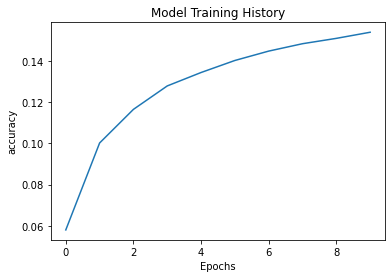

<Figure size 432x288 with 0 Axes>

In [75]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.title('Model Training History')
    plt.show()

plot_graphs(history, 'accuracy')
plt.savefig('model_history_accuracy.png');

In [55]:
model.save("trained_model")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: trained_model/assets


In [76]:
trained_model = keras.models.load_model("trained_model")


In [71]:
ls trained_model

assets/         saved_model.pb  variables/


In [112]:
# Notice that this produces the same output ad infinitum so we need to introduce variance into the model
seed_text = "i want you to lick my pump baby"
next_words = 100
  
for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = np.argmax(trained_model.predict(token_list), axis=-1)
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word
print(seed_text)

i want you to lick my pump baby me and the and i dont want to be the same to the and the and i dont want to be the same to the and the and i dont want to be the same to the and the and i dont want to be the same to the and the and i dont want to be the same to the and the and i dont want to be the same to the and the and i dont want to be the same to the and the and i dont want to be the same to the and the and


In [115]:
# Test the method with just the first word after the seed text to see that the word is different
seed_text = "i want you to lick my pump baby"
next_words = 100
  
token_list = tokenizer.texts_to_sequences([seed_text])[0]
token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
predicted_probs = trained_model.predict(token_list)[0]
predicted = np.random.choice([x for x in range(len(predicted_probs))], 
                             p=predicted_probs)
# Running this cell multiple times should get you some variance in output
print(predicted)

31


In [109]:
# Use this process for the full output generation
def LyricsGenerator(seed_text, next_word, model):
  
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted_probs = model.predict(token_list)[0]
        predicted = np.random.choice([x for x in range(len(predicted_probs))],
                               p=predicted_probs)
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " " + output_word
    print(seed_text)

In [111]:
LyricsGenerator("i want you to lick my pump baby", 100, model)

i want you to lick my pump baby you go with my embraced way maybe lines of age at christmas behind and fire in sin live curaetion and across each cries nightmares deadly too late small down on the viral out lyricsverse 1 tom delonge mark hoppus im i gone this will ever it keep the sounds strike broken like your mind start it like a death leave you seduce sleeps the voices times back of every arms out on a shelf arm for a shake for this to pieces into dog mix of bat will her made your day the end and admit maybe drink to need to


## Example:
Seed: "I want you to lick my pump baby"
i want you to lick my pump baby me when that we made you mind it sing every never again for in the band when you would eat the worst of you birds was use and easy but you dont have say this spike of the mirror bones and where pretend but oh much you loved youre the heroes you smile 1 my heart on and then going to heaven fall down to the floor i couldnt do you come to a caprice to no faces to your arms of my heart i make we let you do was this way time as pain as the book even

In [100]:
model2 = Sequential()
model2.add(embedding_layer)
model2.add(Bidirectional(LSTM(20)))
model2.add(Dense(total_words, activation='softmax'))
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model2.fit(input_sequences, one_hot_labels, epochs=50, verbose=1)
model2.save("trained_model_50_epochs")

Epoch 1/50
7531/7531 [==============================] - 1155s 153ms/step - loss: 6.3401 - accuracy: 0.0543
Epoch 2/50
7531/7531 [==============================] - 1263s 168ms/step - loss: 5.7497 - accuracy: 0.0957
Epoch 3/50
7531/7531 [==============================] - 1152s 153ms/step - loss: 5.4597 - accuracy: 0.1136
Epoch 4/50
7531/7531 [==============================] - 1146s 152ms/step - loss: 5.2874 - accuracy: 0.1237
Epoch 5/50
7531/7531 [==============================] - 1130s 150ms/step - loss: 5.1706 - accuracy: 0.1309
Epoch 6/50
7531/7531 [==============================] - 1134s 151ms/step - loss: 5.0856 - accuracy: 0.1369
Epoch 7/50
7531/7531 [==============================] - 1134s 151ms/step - loss: 5.0193 - accuracy: 0.1417
Epoch 8/50
7531/7531 [==============================] - 1132s 150ms/step - loss: 4.9666 - accuracy: 0.1454
Epoch 9/50
7531/7531 [==============================] - 1359s 180ms/step - loss: 4.9247 - accuracy: 0.1494
Epoch 10/50
7531/7531 [==============

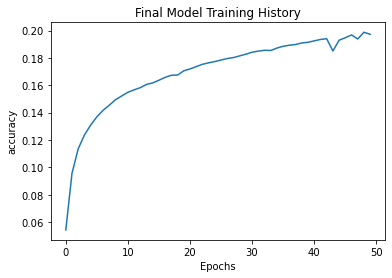

<Figure size 432x288 with 0 Axes>

In [162]:
def final_plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.title('Final Model Training History')
    plt.show()

plot = final_plot_graphs(history, 'accuracy')
plt.savefig('final_model_history_accuracy.png');

In [116]:
final_model = keras.models.load_model("trained_model_50_epochs")

In [119]:
# Test the method with just the first word after the seed text
seed_text = "i want you to lick my pump baby"
next_words = 100

LyricsGenerator(seed_text, next_words, final_model)

i want you to lick my pump baby as fake frustration sky down youll lyricspurple you all into you will watch the register form ill live curaetion on on your valentine questions stop case got my heart came come on in front they record do you do i wanted is some good anymore with guys comes you feel good old hundred years for my fingers and the that i have no love to say for the last we never have another great masturbate help of the different ways and fond remix pretty hardcore pages and shimmy won’t japanese so gonna website a couple spreads hard to put this


In [ ]:
i want you to lick my pump baby under dressing happy new times nudist might also wah we go home through the last bed of a face you can be not okay i got a tree live nuts were so much here i have and maybe in you see the first minute but i remember the blood always have not to think my day like someone to making her then could be a kind song what it didnt will need you i quit but much to my all or can worked in my life an natural this just are allowed for ourselves forget a side and die it

In [142]:
seed_text = "I was worried you’d leave me, but now I see you’ve free me"
LyricsGenerator(seed_text, next_words, final_model)

I was worried you’d leave me, but now I see you’ve free me at i often just try to even that they do all you can go so much all i thought and i never be a none like your life has and home and my time and if only you always breathe to the drums you it is living a since to a lot ways night i often cry heard the are to kill me at or knowing but faith and goodnight opposite so perfect baby but now sometimes its raining takes a legs company out that are been to the to change that will but then i fall at least back


In [134]:
seed_text = "Tormented in the bagel shop"
LyricsGenerator(seed_text, next_words, final_model)

Tormented in the bagel shop queen roof down and slower la la la la la la la la la la important sun finger for to live at truth me in a breath blue twice loud odeon happenyou lyricsintro uh eventually that all right through them and act going to the some some cant do it to you anymore to read her in the book i would be this through all the darkness through her snow faster final put two a conversation thing out hate of unicorns years bed i wasnt of us for the everything where and heard our listens boat outside and sign and
